# Infer ***nucleus***, ***cellmask***, and ***cytoplasm*** from a composite image of cytoplasmic organelles
### Alternative workflow: ***"A"*** (an alternative workflow for images with only cytoplasmic organelles, NO **nuclei** or **cell membrane** makers, one cell per field of view)
--------------


## **OBJECTIVES**:
### <input type="checkbox"/> Infer sub-cellular component #1: ***cytoplasm***
Segment the ***cytoplasm*** from a composite image of multiple organelle markers combined. The ***cell*** and ***nucleus*** masks will be derived from this mask.

> ###### **Biological relevance: The combination of organelle markers used to create the composite image for the cytoplasm segmentation is based on the assumption that the organelle labels used will "fill up" the entire cytoplasm (not including the nucleus). This is NOT the most accurate method to determine the cell area, but is required in the case where membrane and nuclei markers can not or are not included. This largely depends on the organelle labeles used and the cell type.**
>
> ###### ***It is important to consider specifics of your system as the cell type and labeling method may differ from the example above.***

### <input type="checkbox"/> Infer sub-cellular component #2️: ***nucleus***
Segment the ***nucleus*** from an exclusive or (XOR) of the ***cytoplasm*** mask and a hole-filled version of the ***cytoplasm*** mask.


### <input type="checkbox"/> Infer sub-cellular component #3️: ***cellmask***
Segment the ***cellmask*** by combining the ***nucleus*** and ***cytoplasm*** masks.

> ###### 📝 **this workflow is optimized for images with one fluorescent cell in the field of view**


---------
## **masks_A workflow**
### summary of steps

➡️ **EXTRACTION**
- **`STEP 1`** - Create composite image

    - determine weight to apply to each channel of the intensity image (w# = user input)
    - rescale summed image intensities (rescale = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

    - rescale intensity of composite image (min=0, max=1)
    - median filter (median size = user input)
    - gaussian filter (sigma = user input)
    
- **`STEP 3`** - Log transform + Scharr edge detection

    - perform a log transformation on the image
    - apply Scharr edge detection filter
    - combine log image and Scharr edge filtered intensity image
 
**CORE PROCESSING**
- **`STEP 4`** - Global + local thresholding (AICSSeg – MO)

    - apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

**POST-PROCESSING**
- **`STEP 5`** - Remove small holes and objects

    - fill holes (hole size = user input)
    - remove small objects (object size = user input)
    - filter method = (method = user input)

**POST-POST-PROCESSING**
- **`STEP 6`** - Create nucleus mask from cytoplasm mask

    - binary dilation
    - fill nucleus (hole size = user input)
    - binary erosion
    - logical **XOR** of the cytoplasm and the filled in cytoplasm resulting in the nucleus and any artifacts from dilation/erosion
    - remove small objects (object size = user input)


- **`STEP 7`** - Create cellmask from cytoplasm and nucleus mask

    - logical **OR** of the nucleus and cytoplasm
    - fill small holes (hole size = user input)
    - remove small objects (object size = user input)

**OUTPUT** ➡️ 
- **`STEP 8`** - Stack masks

    - Stack masks in order of nucleus, cellmask and cytoplasm mask

---------
## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook. 

In [1]:
from pathlib import Path
import os

import numpy as np
import napari
from napari.utils.notebook_display import nbscreenshot
from skimage.morphology import binary_dilation, binary_erosion

from infer_subc.core.file_io import (read_czi_image, 
                                     export_inferred_organelle,
                                     list_image_files,
                                     sample_input)
                  
from infer_subc.core.img import *
from infer_subc.organelles import non_linear_cellmask_transform

%load_ext autoreload
%autoreload 2

## **LOAD AND READ IN IMAGE FOR PROCESSING**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [2]:
### USER INPUT REQUIRED ###
# If using the sample data, set cell_type to "neuron":
# If not using the sample data, set cell_type to None
sample_data_type = "neuron"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0

# If you are not using the sample data, please edit "USER SPECIFIED" as necessary.
## Define the path to the directory that contains the input image folder.
data_root_path = Path("USER SPECIFIED")

# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
im_type = "USER SPECIFIED"

## Specify which subfolder that contains the input data and the input data file extension
in_data_path = data_root_path / "USER SPECIFIED"

## Specify the output folder to save the segmentation outputs if.
## If its not already created, the code below will creat it for you
out_data_path = data_root_path / "USER SPECIFIED"

#### &#x1F3C3; **Run code; no user input required**

In [3]:
# If sample_data_type is set "neuron", then the sample data is used and the directories are set
if sample_data_type != None:
    data_root_path, im_type, in_data_path, out_data_path = sample_input(sample_data_type)

In [3]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

img_file_list = list_image_files(in_data_path,im_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

In [4]:
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

# ***EXTRACTION prototype - masks_A***

## **`STEP 1` - Create composite image**

- determine weight to apply to each channel of the intensity image (w# = user input)
- rescale summed image intensities (rescale = user input)

In [5]:
###################
# INPUT
###################

# Creating a composite image

w0 = 1
w1 = 4
w2 = 1
w3 = 1
w4 = 0
w5 = 2
w6 = 0
w7 = 0
w8 = 0
w9 = 0

rescale = True

struct_img_raw = make_aggregate(img_data,
               weight_ch0= w0,
               weight_ch1= w1,
               weight_ch2= w2,
               weight_ch3= w3,
               weight_ch4= w4,
               weight_ch5= w5,
               weight_ch6= w6,
               weight_ch7= w7,
               weight_ch8= w8,
               weight_ch9= w9,
               rescale = rescale)

# weights =  [0, 4, 1, 1, 2, 2]
# struct_img_raw = weighted_aggregate(img_data, *weights)

# ***PRE-PROCESSING prototype - masks_A***

## **`STEP 2` - Rescale and smooth image**

- rescale intensity of composite image (min=0, max=1)
- median filter (median size = user input)
- gaussian filter (sigma = user input)

> **NOTE**: No smoothing was done here because these test images were already pre-processed.

In [6]:
med_filter_size = 0
gaussian_smoothing_sigma = 0

structure_img_smooth = scale_and_smooth(struct_img_raw,
                                        median_size = med_filter_size, 
                                        gauss_sigma = gaussian_smoothing_sigma)

## **`STEP 3` - Log transform + Scharr edge detection**

- perform a log transformation on the image
- apply Scharr edge detection filter
- combine log image and Scharr edge filtered intensity image

In [7]:
# log scale the image, apply the scharr edge detection filter to logged image, add the two images together
composite_cellmask = non_linear_cellmask_transform(structure_img_smooth)

# ***CORE-PROCESSING prototype - masks_A***

## **`STEP 4` - Global + local thresholding (AICSSeg – MO) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package**

- apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

In [8]:
# threshold the composite image after log/edge detection using the MO filter function from aicssegmentation - this applies a global threshold, then a local threshold to produce a semantic segmentation
thresh_method = 'ave'
cutoff_size =  50
thresh_adj = 0.05

bw = masked_object_thresh(composite_cellmask, 
                          global_method=thresh_method, 
                          cutoff_size=cutoff_size, 
                          local_adjust=thresh_adj)

# ***POST-PROCESSING prototype - masks_A***

## **`STEP 5` - Remove small holes and objects**

- fill holes (hole size = user input)
- remove small objects (object size = user input)
- filter method = (method = user input)

> ###### 📝 **the size parameters are by convention defined as one dimensional "width", so the inputs to the functions are _squared_ i.e. raised to the power of 2: `**2` for 2D analysis. For volumetric (3D) analysis this would be _cubed_: `**3`.**

In [9]:
hole_min_width = 0
hole_max_width = 30

small_object_width = 10

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(bw, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size= small_object_width,
                                           method=fill_filter_method)

###### Labels a boolean version of the cytoplasm mask to a uint16 array

In [10]:
cytoplasm_mask = label_bool_as_uint16(cleaned_img2)

Define `_infer_cytoplasm_fromcomposite` function

In [11]:
##########################
# infer_cytoplasm_fromcomposite
# alternative workflow "a"
##########################
def _infer_cytoplasm_fromcomposite(in_img: np.ndarray,
                                  weights: list[int],
                                  median_sz: int,
                                  gauss_sig: float,
                                  mo_method: str,
                                  mo_adjust: float,
                                  mo_cutoff_size: int,
                                  min_hole_w: int,
                                  max_hole_w: int,
                                  small_obj_w: int,
                                  fill_filter_method: str
                                  ) -> np.ndarray:
    """
    Procedure to infer cellmask from linear unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    weights:
        a list of int that corresond to the weights for each channel in the composite; use 0 if a channel should not be included in the composite image
    nuclei_labels: 
        a 3d image containing the inferred nuclei labels
    median_sz: 
        width of median filter for _cellmask_ signal
    gauss_sig: 
        sigma for gaussian smoothing of _cellmask_ signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w: 
        hole filling cutoff for cellmask signal post-processing
    small_obj_w: 
        minimu object size cutoff for cellmask signal post-processing
    watershed_method:
        determines if the watershed should be run 'sice-by-slice' or in '3D' 

    Returns
    -------------
    cellmask_mask:
        a logical/labels object defining boundaries of cellmask

    """
    ###################
    # EXTRACT
    ###################
    struct_img = weighted_aggregate(in_img, *weights)

    ###################
    # PRE_PROCESSING
    ###################                         
    struct_img = scale_and_smooth(struct_img,
                                   median_size = median_sz, 
                                   gauss_sigma = gauss_sig)
    

    struct_img_non_lin = non_linear_cellmask_transform(struct_img)

    ###################
    # CORE_PROCESSING
    ###################
    struct_obj = masked_object_thresh(struct_img_non_lin, 
                                      global_method=mo_method, 
                                      cutoff_size=mo_cutoff_size, 
                                      local_adjust=mo_adjust)               

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(struct_obj, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size= small_obj_w,
                                             method=fill_filter_method)

    ###################
    # POST- POST_PROCESSING
    ###################
    cellmask_out = label_bool_as_uint16(struct_obj)

    return cellmask_out

Run `_infer_cytoplasm_fromcomposite` function

In [12]:
###################
# PARAMETERS
###################   
weights = [1, 4, 1, 1, 0, 2]
median_sz = 0
gauss_sig = 0
mo_method = "ave"
mo_adjust = 0.05
mo_cutoff_size = 50
hole_min_width = 0
hole_max_width = 30
small_obj_w = 10
fill_filter_method = '3D'

_CY_object = _infer_cytoplasm_fromcomposite(img_data,
                                            weights,
                                            median_sz,
                                            gauss_sig,
                                            mo_method,
                                            mo_adjust,
                                            mo_cutoff_size,
                                            hole_min_width,
                                            hole_max_width,
                                            small_obj_w,
                                            fill_filter_method) 

_CY_object.dtype

dtype('uint16')

In [13]:
np.all(cytoplasm_mask == _CY_object)

False

# ***POST-POST-PROCESSING prototype - masks_A***

## **`STEP 6` - Create nucleus mask from cytoplasm mask**

- binary dilation
- fill nucleus (hole size = user input)
- binary erosion

In [14]:
cytoplasm_dilated = binary_dilation(cytoplasm_mask)

hole_min_width = 0
hole_max_width = 400
small_obj_width = 0
fill_filter_method = "3D"
cytoplasm_filled = fill_and_filter_linear_size(cytoplasm_dilated, hole_min=hole_min_width, hole_max=hole_max_width, min_size=small_obj_width, method=fill_filter_method)

cytoplasm_eroded = binary_erosion(cytoplasm_filled)

- logical **XOR** of the cytoplasm and the filled in cytoplasm resulting in the nucleus and any artifacts from dilation/erosion

In [15]:
nuclei_xor = np.logical_xor(cytoplasm_mask, cytoplasm_eroded)

- remove small objects (object size = user input)

In [16]:
nuc_small_object_width = 20

nuc_cleaned_img = fill_and_filter_linear_size(nuclei_xor, hole_min=0, hole_max=0, min_size=nuc_small_object_width, method="3D")

###### Labels a boolean version of the nuclei labels to a uint16 array

In [17]:
###################
# LABELING
###################
# create instance segmentation based on connectivity
nuclei_labels = label_bool_as_uint16(nuc_cleaned_img)

In [18]:
nuclei_labels.dtype

dtype('uint16')

Define `_infer_nuclei_fromcytoplasm` function

In [19]:
##########################
#  _infer_nuclei_fromcytoplasm
##########################
def _infer_nuclei_fromcytoplasm(cytoplasm_mask: np.ndarray, 
                                nuc_min_hole_w: int,
                                nuc_max_hole_w: int,
                                nuc_fill_method: str,
                                small_obj_w: int,
                                fill_filter_method: str
                                ) -> np.ndarray:
    """
    Procedure to infer nuclei from linear unmixed input.

    Parameters
    ------------
    cytoplasm_mask: np.ndarray
        a 3d image of the cytoplasm segmentation
    max_hole_w: int
        hole filling cutoff to fill the nuclei
    small_obj_w: int
        object size cutoff to remove artifacts from dilation/erosion steps
    fill_filter_method: str
        to filter artifacts in "3D" or "slice-by-slice"

    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """

    ###################
    # PRE_PROCESSING
    ###################                
    cytoplasm_dilated = binary_dilation(cytoplasm_mask)

    cytoplasm_filled = fill_and_filter_linear_size(cytoplasm_dilated, 
                                                   hole_min=nuc_min_hole_w, 
                                                   hole_max=nuc_max_hole_w, 
                                                   min_size=0, 
                                                   method=nuc_fill_method)

    cytoplasm_eroded = binary_erosion(cytoplasm_filled)

    ###################
    # CORE_PROCESSING
    ###################
    nuclei_xor = np.logical_xor(cytoplasm_mask, cytoplasm_eroded)

    ###################
    # POST_PROCESSING
    ###################
    nuclei_object = fill_and_filter_linear_size(nuclei_xor, 
                                                hole_min=0, 
                                                hole_max=0, 
                                                min_size=small_obj_w,
                                                method=fill_filter_method)

    nuclei_labels = label_uint16(nuclei_object)

    return nuclei_labels

Run `_infer_nuclei_fromcytoplasm` function

In [32]:
nuc_min_hole_w = 0
nuc_max_hole_w = 400
nuc_fill_method = "3D"
small_obj_w = 20
fill_filter_method = "3D"

_NU_object = _infer_nuclei_fromcytoplasm(cytoplasm_mask,
                                nuc_min_hole_w,
                                nuc_max_hole_w,
                                nuc_fill_method,
                                small_obj_w,
                                fill_filter_method)

_NU_object.dtype

dtype('uint16')

## **`STEP 7` - Create cellmask from cytoplasm and nucleus mask**

- logical **OR** of the nucleus and cytoplasm

In [33]:
cell = np.logical_or(_NU_object, _CY_object)

- fill small holes (hole size = user input)
- remove small objects (object size = user input)

In [34]:
min_hole_width = 0
max_hole_width = 0
small_obj_width = 0
fill_method = "3D"

cleaned_img = fill_and_filter_linear_size(cell, 
                                          hole_min=min_hole_width, 
                                          hole_max=max_hole_width, 
                                          min_size=small_obj_width, 
                                          method=fill_method)

###### Labels a boolean version of the cell mask to a uint16 array

In [35]:
# create instance segmentation based on connectivity
cell_mask = label_bool_as_uint16(cleaned_img)

In [36]:
cell_mask.dtype

dtype('uint16')

# ***EXPORT prototype - masks_A***

## **`STEP 8` - Stack masks**

- Stack masks in order of nucleus, cellmask and cytoplasm mask

In [37]:
stack = stack_masks(nuc_mask=_NU_object, cellmask=cell_mask, cyto_mask=_CY_object)

In [38]:
out_file_n = export_inferred_organelle(stack, "masks_A", meta_dict, out_data_path)

saved file: 20230727_C2-121_conditioned_well 4_cell 3_untreated_Linear unmixing_0_cmle.ome-masks_A


#### &#x1F6D1; &#x270D; **User Input Required:**

In [ ]:
## When using the sample data in part 2, quantification is carried out on both the neuron and astrocyte data through
## batch processing. to_batch = True copies the segmentation to the batch processing file location in addition to the
## segmentation folder.

to_batch = True

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
if to_batch and sample_data_type == 'neuron':
    out_file_b = export_inferred_organelle(stack, "masks", meta_dict, Path(os.getcwd()).parents[1] / "sample_data" /  "batch_example" / "seg")

## **Visualize `nucleus`, `cellmask` and `cytoplasm`**

In [40]:
viewer_masks_A = napari.Viewer(title = "masks_A",
                           ndisplay=3)
viewer_masks_A.grid.enabled = True

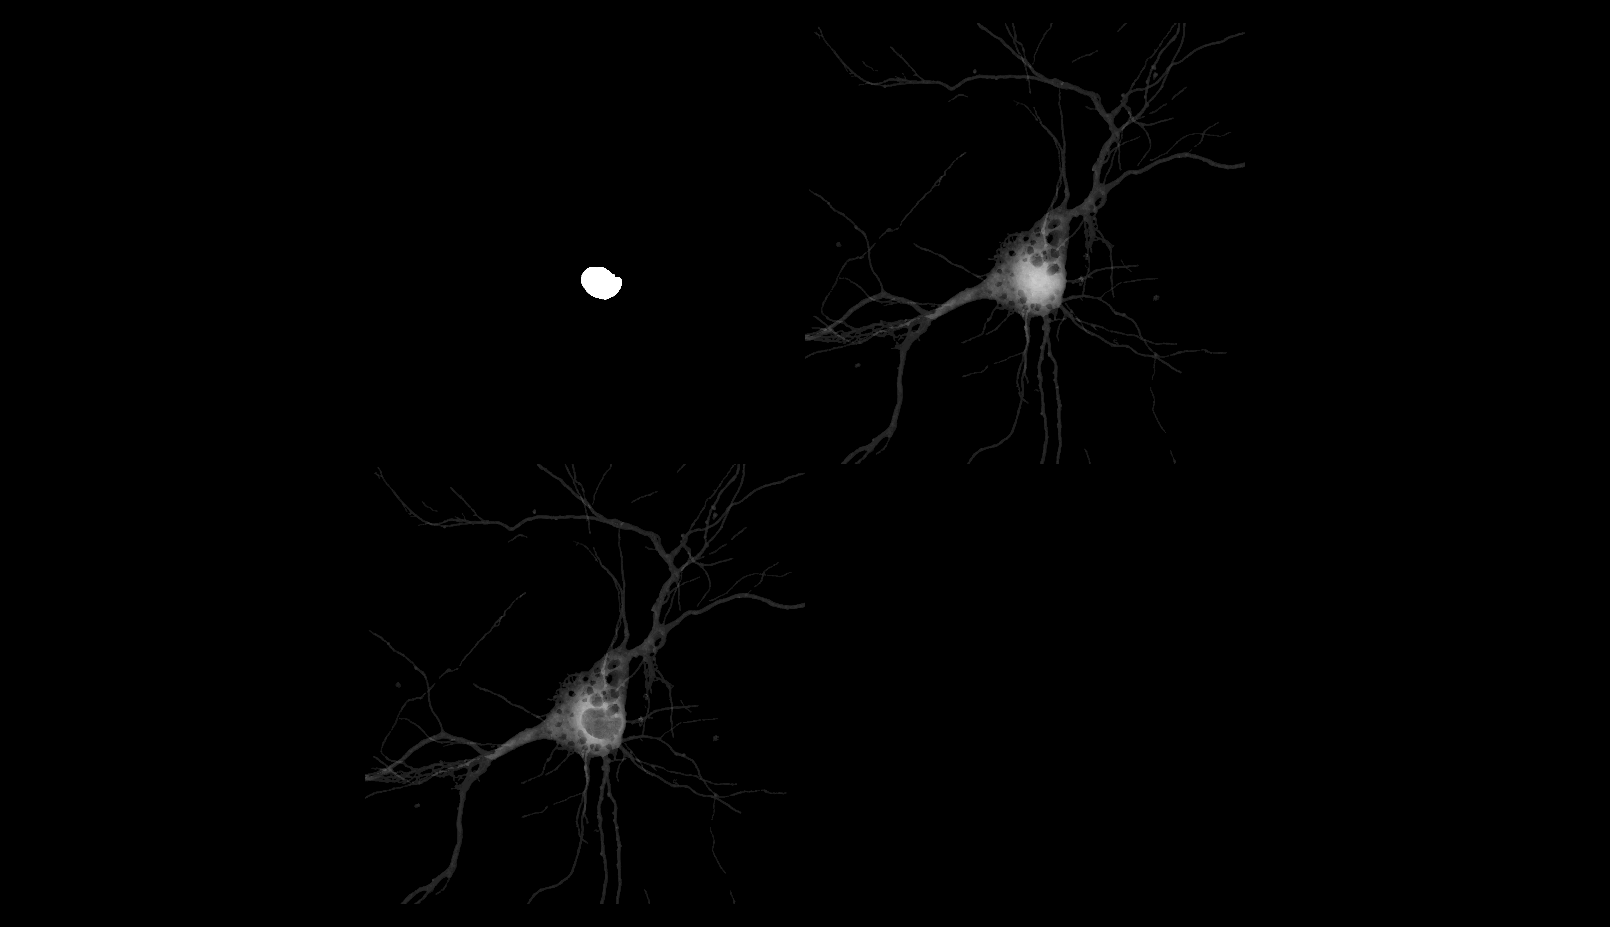

In [41]:
viewer_masks_A.add_image(stack[2].astype(bool),
                      scale = scale,
                      name = 'Cytoplasm',
                      rendering = 'average')

viewer_masks_A.add_image(stack[1].astype(bool),
                      scale = scale,
                      name = 'Cellmask',
                      rendering = 'average')

viewer_masks_A.add_image(stack[0].astype(bool),
                      scale = scale,
                      name = 'Nucleus')

viewer_masks_A.reset_view()

nbscreenshot(viewer_masks_A,
             canvas_only = True)

-------------
### NEXT: INFER LYSOSOME

proceed to [1.2_infer_lysosome.ipynb](./1.2_infer_lysosome.ipynb)